# Using categorical features with scikit-learn

While scikit-learn is a powerful powerful tool, sometimes it can be a pain in the neck. Using categorical features can be one such time, where you're sure to miss the simple world of statsmodels regressions.

<p class="reading-options">
  <a class="btn" href="/classification/scikit-learn-and-categorical-features">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/classification/notebooks/Scikit-learn and categorical features.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="#">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

## Our dataset

We'll be using the same dataset we've been using for all of our logistic regression and classification problems: **scarf-knitting!** We've been keeping a record of the past few scarves we've tried to make, logging their length, needle size, color, and whether we completed them or not.

In [30]:
import pandas as pd

df = pd.DataFrame([
    { 'length_in': 55, 'large_gauge': 1, 'color': 'orange', 'completed': 1 },
    { 'length_in': 55, 'large_gauge': 0, 'color': 'orange', 'completed': 1 },
    { 'length_in': 55, 'large_gauge': 0, 'color': 'brown', 'completed': 1 },
    { 'length_in': 60, 'large_gauge': 0, 'color': 'brown', 'completed': 1 },
    { 'length_in': 60, 'large_gauge': 0, 'color': 'grey', 'completed': 0 },
    { 'length_in': 70, 'large_gauge': 0, 'color': 'grey', 'completed': 1 },
    { 'length_in': 70, 'large_gauge': 0, 'color': 'orange', 'completed': 0 },
    { 'length_in': 82, 'large_gauge': 1, 'color': 'grey', 'completed': 1 },
    { 'length_in': 82, 'large_gauge': 0, 'color': 'brown', 'completed': 0 },
    { 'length_in': 82, 'large_gauge': 0, 'color': 'orange', 'completed': 0 },
    { 'length_in': 82, 'large_gauge': 1, 'color': 'brown', 'completed': 0 },
])

df.head()

,length_in,large_gauge,color,completed
0,55,1,orange,1
1,55,0,orange,1
2,55,0,brown,1
3,60,0,brown,1
4,60,0,grey,0


All of this has been in pursuit of one question: **if someone suggests I make a particular scarf, will I actually finish it?** Since the answer is a yes/no question we know it's a **classification problem.**

## Without categorical features

Last time we tried to create a classifier, _we didn't include color_. We figured it just wouldn't be important! Our processed just used length and knitting needle gauge, and went something like this:

In [43]:
# Build our features and labels
# Only keep the columns we're interested in
X = df[['length_in', 'large_gauge']]
y = df.completed

In [44]:
from sklearn.linear_model import LogisticRegression

# Create a new classifier and train it with our data
clf = LogisticRegression(C=1e9, solver='lbfgs', max_iter=4000)
clf.fit(X, y)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Instead of jumping into predictions, we might as well just use [ELI5](http://eli5.readthedocs.io/) to see what the **feature importances** are inside of our model.

In [46]:
import eli5

feature_names = list(X.columns)
label_names = ['not completed', 'completed']

eli5.show_weights(clf,
                  feature_names=feature_names,
                  target_names=label_names)

Weight?,Feature
+12.085,<BIAS>
+2.961,large_gauge
-0.183,length_in


Large gauge needles make us more successful, longer scarves make us less successful. It's understandable and reasonable, yet we always need more, and so we ask ourselves: **what if we did include color?** It wasn't that hard when we did regression with statsmodels, right? All we had to do was convert our formula a little bit.

**Without color:**

```python
model = smf.logit("completed ~ length_in + large_gauge", data=df)
```

**With color:**

```python
model = smf.logit("completed ~ length_in + large_gauge + C(color, Treatment('orange'))", data=df)
```

The second one uses orange as a reference category - the odds ratios for grey and brown are in _reference to orange_, so you can make statements like "your odds of success double if using brown yarn as compared to orange yarn."

Unfortunately it **isn't that easy when it comes to scikit-learn**.

## Categoricals in scikit-learn

To figure out how to set sklearn up, let's first look at our statsmodels output. How much does each feature affect whether we can make the scarf or not?

In [55]:
import statsmodels.formula.api as smf

# Use the formula method to perform a regression
model = smf.logit("completed ~ length_in + large_gauge + C(color, Treatment('orange'))", data=df)
model.fit()

# Don't display the regression results! Just skip ahead to the odds ratios
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs

Optimization terminated successfully.
         Current function value: 0.424906
         Iterations 7


,coef,odds ratio,pvalue,name
Intercept,12.124529,184338.541216,0.134160,Intercept
"C(color, Treatment('orange'))[T.brown]",0.459412,1.583143,0.838740,"C(color, Treatment('orange'))[T.brown]"
"C(color, Treatment('orange'))[T.grey]",1.470759,4.352538,0.520474,"C(color, Treatment('orange'))[T.grey]"
length_in,-0.194425,0.823308,0.123631,length_in
large_gauge,2.881375,17.838786,0.311104,large_gauge


In the output from statsmodels, we have **five columns**:

* the intercept
* color (brown)
* color (grey)
* length in inches
* large gauge needles or not

This is good and true and right and great. Let's compare that to our scikit-learn weights, which we haven't taught about color yet:

In [61]:
eli5.show_weights(clf,
                  feature_names=feature_names,
                  target_names=label_names)

Weight?,Feature
+12.085,<BIAS>
+2.961,large_gauge
-0.183,length_in


Scikit-learn gives us **three coefficients**:
    
* The bias (intercept)
* large gauge needles or not
* length in inches

It's three columns because it's **one column for each of our features**, plus an intercept. Since we're giving our model two things: `length_in` and `large_gauge`, we get 2 + 1 = 3 different coefficients.

The big big problem is that we need to somehow match the statsmodels output, and **increase these 3 columns to 5 columns.** We can't just add a "color" column, we need a "color is grey" column and a "color is brown" column!

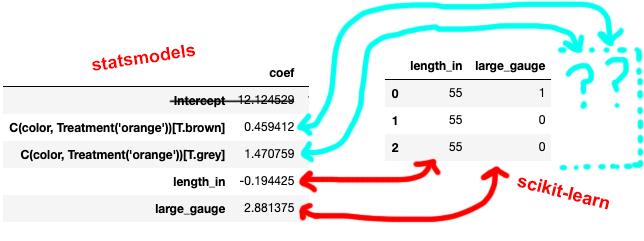

## Adding columns

### Manually adding columns

We need two new columns: `color_brown` and `color_grey`. They should be 0 where the color matches, and 1 where it doesn't. It's pretty easy to do this manually.

In [67]:
# True/False becomes 1/0
df['color_brown'] = (df.color == 'brown').astype(int)
df['color_grey'] = (df.color == 'grey').astype(int)
df.head()

,length_in,large_gauge,color,completed,color_brown,color_grey
0,55,1,orange,1,0,0
1,55,0,orange,1,0,0
2,55,0,brown,1,1,0
3,60,0,brown,1,1,0
4,60,0,grey,0,0,1


When we run `df.color == 'brown'`, it returns `True` or `False` for every single row. We use `.astype(int)` to convert this into an integer: `True` magically becomes 1 and `False` becomes 0. And there we go! Two new columns, all based on the color.

Now that we have our two new columns, we can create our list of features and train a new classifier.

In [63]:
# Pick the features we're interested in using
X = df[['length_in', 'large_gauge', 'color_brown', 'color_grey']]
y = df.completed

# Create and train our classifier
clf = LogisticRegression(C=1e9, solver='lbfgs', max_iter=4000)
clf.fit(X, y)

To confirm our new features were added, we can check eli5's feature importances.

In [66]:
feature_names = list(X.columns)
label_names = ['not completed', 'completed']

eli5.show_weights(clf,
                  feature_names=feature_names,
                  target_names=label_names)

Weight?,Feature
+12.124,<BIAS>
+2.881,large_gauge
+1.471,color_grey
+0.459,color_brown
-0.194,length_in


### Automatically adding columns

Doing the whole "are you a match? turn into a number!" thing is fine if it's just a couple colors - brown and grey, in this case - what if we had _ten_ colors? Or we weren't sure what all the colors were? Or we're really really really bad with the keyboard and really really really prone to typos?

Let's automate this!

Pandas actually has a method that breaks apart a category into multiple columns, called `pd.get_dummies`:

In [69]:
pd.get_dummies(df.color, prefix='color')

,color_brown,color_grey,color_orange
0,0,0,1
1,0,0,1
2,1,0,0
3,1,0,0
4,0,1,0
5,0,1,0
6,0,0,1
7,0,1,0
8,1,0,0
9,0,0,1


It has such a goofy name because representing categories like this is called using ["dummy variables"](https://stattrek.com/multiple-regression/dummy-variables.aspx).

To get the right number of columns - brown and grey, but _not orange_ - we'll need to drop `color_orange`.

In [70]:
color_features = pd.get_dummies(df.color, prefix='color').drop('color_orange', axis=1)
color_features.head()

,color_brown,color_grey
0,0,0
1,0,0
2,1,0
3,1,0
4,0,1


I usually do this for each categorical column, so we end up with a few different dataframes. Once we have all of our categorical variables encoded, we'll **combine them with the original, non-categorical features**.

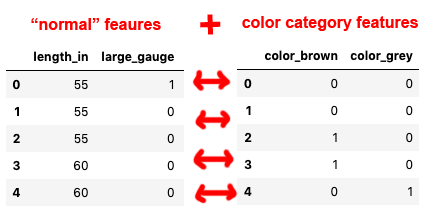

In this case we only have one categorical column, so it's a little anticlimactic.

In [98]:
# Take our numeric features and our output label
features = df[['length_in', 'large_gauge', 'completed']]

# Convert color since it's categorical
color_features = pd.get_dummies(df.color, prefix='color').drop('color_orange', axis=1)

# Combine into one dataframe
train_df = pd.concat([numeric_features, color_features], axis=1)
train_df.head()

,length_in,large_gauge,completed,color_brown,color_grey
0,55,1,1,0,0
1,55,0,1,0,0
2,55,0,1,1,0
3,60,0,1,1,0
4,60,0,0,0,1


Now we can train, test, and see what our classifier's feature importances look like.

In [76]:
# Pick the features we're interested in using
X = train_df.drop('completed', axis=1)
y = train_df.completed

# Create and train our classifier
clf = LogisticRegression(C=1e9, solver='lbfgs', max_iter=4000)
clf.fit(X, y)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
feature_names = list(X.columns)
label_names = ['not completed', 'completed']

eli5.show_weights(clf,
                  feature_names=feature_names,
                  target_names=label_names)

Weight?,Feature
+12.124,<BIAS>
+2.881,large_gauge
+1.471,color_grey
+0.459,color_brown
-0.194,length_in


**Same coefficients as before!**

Did it take a few more lines of code? _Maybe!_ But I promise `pd.get_dummies` is far, far easier when we don't want to type out each and ever possible value of a column. If we get comfortable with using it, it'll also be a great way to impress friends and neighbors!

## The reference column

An important question we might have is **why did we have to drop `color_orange`**? Wouldn't life be better if we used _all the columns_? Isn't _more information better?_

Turns out the answer is **actually, no.** We can go read about the [dummy variable trap and collinearity](https://www.algosome.com/articles/dummy-variable-trap-regression.html), but we can probably take an easier route there instead.

When we're knitting a scarf, we need to use _some color_, right? Orange or brown or grey? In this same way, doing better or worse is always some sort of comparison, like:

* if we add an inch of scarf, our odds of completing it go down such-and-such amount (55" vs 56")
* if we're using a large gauge needle, our odds of finishing go up such-and-such amount (small gauge vs large gauge)
* if we use **grey yarn**, our odds of finishing go up such-an-such amount (grey yarn vs..... **????**)

It's that final **????** that is our reference category. We can't compare grey yarn to _no yarn_. The column we drop is our reference category, the one we're comparing it to. **Since we dropped orange yarn, in this case it's grey yarn as compared to orange yarn.**

When we drop a column, this is technically called ["one-hot encoding"](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). It's the extra step after dummy encoding where we pick what our reference is.

There are more intense math reasons why you need to drop it (everyone will break! your math will falter! nothing will work!) [which you're welcome to read about](https://www.algosome.com/articles/dummy-variable-trap-regression.html), but just remember to always drop a column and you'll be fine.

## Using our new classifier

Let's quickly rebuild our new classifier and see how it performs.

First we'll use the `pd.get_dummies` technique to build our training dataset.

In [79]:
features = df[['length_in', 'large_gauge', 'completed']]
color_features = pd.get_dummies(df.color, prefix='color').drop('color_orange', axis=1)

train_df = pd.concat([numeric_features, color_features], axis=1)
train_df.head(3)

,length_in,large_gauge,completed,color_brown,color_grey
0,55,1,1,0,0
1,55,0,1,0,0
2,55,0,1,1,0


Then we'll pick them apart into features and labels, and create a new classifier. We **won't train it yet**, as that's what cross validations is for. In cross validation, our classifier will be trained and tested multiple times without us doing anything.

In [90]:
# Pick the features we're interested in using
X = train_df.drop('completed', axis=1)
y = train_df.completed

# Create our classifier, but don't train it
clf = LogisticRegression(C=1e9, solver='lbfgs', max_iter=4000)

Time for the moment of truth: **how's it do?**

In [95]:
from sklearn.model_selection import cross_val_score

# Split into four groups and test four times
cross_val_score(clf, X, y, cv=4)

array([0.66666667, 1.        , 0.66666667, 0.5       ])

### Comparing classifiers

Ouch, that didn't do all too well. Under 50% a lot of the time, that's even worse than chance! **Let's compare to our original classifier that ignores color.**

In [96]:
# Only use length and gauge as features
X = df[['length_in', 'large_gauge']]
y = df.completed

cross_val_score(clf, X, y, cv=4)

array([0.66666667, 1.        , 0.66666667, 0.5       ])

Our more basic classifier that ignored color actually does rather well - always over fifty percent accurate! Why is that?

### Deep dark secrets

If we wanted to get complicated, we could talk about bad signals and p values and color not having much of a relationship to the output and how logistic regression works and this or thator another thing. But instead, here's a deep dark secret of data science: **we probably don't really care.** All we care about is that is _works better_, and not so much _why_.

When you're doing data science, the vast majority of the time you're just trying to make sure you get the most right answer the largest percent of time. When something works you don't stop too hard to judge it, you just high five your computer and chalk up another success story. Delving deep into how your models work might help you tweak and improve them further, but you're usually just looking to up your accuracy, regardless of what makes sense.

Slogan: **If it works better, do it.**

Depending on your situation, this idea can be either beautifully relaxing or terribly irresponsible, and it's something that will come up again and again as we move through different projects.

## Review

In this section we discussed using **categorical features** in scikit-learn. While statsmodels makes it easy to use categorical inputs, scikit-learn involves a fair bit of trouble.

One technique is **manually creating new columns**, converting `True`/`False` checks into ones and zeroes. The other is **automatic column creation** with `pd.get_dummies`, which is a good choice if you have larger numbers of categories.

We also discussed the concepts of **dummy variables** and **one-hot encoding**, which allow us to establish a reference category for all of our comparisons. We didn't go into the math, but we heard that if we forget to drop a column we'll be in trouble!

## Discussion topics

TODO